In [4]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 2452, done.
remote: Counting objects: 100% (2452/2452), done.
remote: Compressing objects: 100% (2443/2443), done.
remote: Total 370759 (delta 9), reused 2449 (delta 9), pack-reused 368307
Receiving objects: 100% (370759/370759), 2.03 GiB | 41.98 MiB/s, done.
Resolving deltas: 100% (1092/1092), done.
Checking out files: 100% (75952/75952), done.


In [5]:
!ls Fruit-Images-Dataset

LICENSE  papers  readme.md  src  Test  test-multiple_fruits  Training


In [0]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [47]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Hyperparameters

In [0]:
batch_size = 128
epochs = 10
log_interval = 10
x_dim = 100
y_dim = 100
nb_channels = 3
embedding_dim = 2048
base_dir = 'Fruit-Images-Dataset'

## Load data

In [0]:
def load_dataset(data_path):
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([torchvision.transforms.ToTensor()])
    )
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return data_loader

train_loader = load_dataset(f'{base_dir}/Training')
test_loader = load_dataset(f'{base_dir}/Test')

## Example image

In [0]:
def plot_img(img):
  plt.figure()
  plt.imshow(img.numpy())
  plt.show()

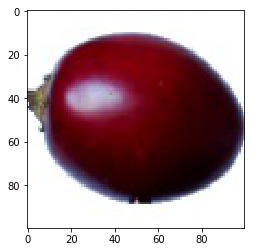

In [51]:
img = next(iter(train_loader))[0][0]
img = img.permute(1, 2, 0)
img = img.view(img.shape[0], img.shape[1], nb_channels)
plot_img(img)

## Models

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(x_dim*y_dim*nb_channels, embedding_dim)
        self.fc21 = nn.Linear(embedding_dim, embedding_dim)
        self.fc22 = nn.Linear(embedding_dim, embedding_dim)
        self.fc3 = nn.Linear(embedding_dim, embedding_dim)
        self.fc4 = nn.Linear(embedding_dim, x_dim*y_dim*nb_channels)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x_dim*y_dim*nb_channels))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [0]:

class VAE_CNN(nn.Module):
    def __init__(self):
        super(VAE_CNN, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv31 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn31 = nn.BatchNorm2d(128)
        self.conv32 = nn.Conv2d(128, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn32 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(25 * 25 * 16, embedding_dim)
        self.fc_bn1 = nn.BatchNorm1d(embedding_dim)
        self.fc21 = nn.Linear(embedding_dim, embedding_dim)
        self.fc22 = nn.Linear(embedding_dim, embedding_dim)

        # Sampling vector
        self.fc3 = nn.Linear(embedding_dim, embedding_dim)
        self.fc_bn3 = nn.BatchNorm1d(embedding_dim)
        self.fc4 = nn.Linear(embedding_dim, 25 * 25 * 16)
        self.fc_bn4 = nn.BatchNorm1d(25 * 25 * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()

    def encode(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv31 = self.relu(self.bn31(self.conv31(conv3)))
        conv32 = self.relu(self.bn32(self.conv32(conv31)))
        conv4 = self.relu(self.bn4(self.conv4(conv32))).view(-1, 25 * 25 * 16)

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)
        
        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 16, 25, 25)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        return self.conv8(conv7).view(-1, 3, 100, 100)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Loss

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, x_dim*y_dim*nb_channels), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [0]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")
        self.bce_loss = nn.BCELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_rec = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_rec + loss_KLD

In [0]:
model = VAE_CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = CustomLoss()

In [0]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_func(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [0]:
import os
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_func(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, nb_channels, x_dim, y_dim)[:n]])
                os.makedirs('results', exist_ok=True)
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

Train Epoch: 1 [0/56781 (0%)]	Loss: 23256.060547
Train Epoch: 1 [1280/56781 (2%)]	Loss: 8380.483398
Train Epoch: 1 [2560/56781 (5%)]	Loss: 3532.291016
Train Epoch: 1 [3840/56781 (7%)]	Loss: 1864.223633
Train Epoch: 1 [5120/56781 (9%)]	Loss: 1372.826172
Train Epoch: 1 [6400/56781 (11%)]	Loss: 1135.243896
Train Epoch: 1 [7680/56781 (14%)]	Loss: 995.673157
Train Epoch: 1 [8960/56781 (16%)]	Loss: 970.266785
Train Epoch: 1 [10240/56781 (18%)]	Loss: 815.780396
Train Epoch: 1 [11520/56781 (20%)]	Loss: 822.796631
Train Epoch: 1 [12800/56781 (23%)]	Loss: 807.576965
Train Epoch: 1 [14080/56781 (25%)]	Loss: 765.655457
Train Epoch: 1 [15360/56781 (27%)]	Loss: 677.379456
Train Epoch: 1 [16640/56781 (29%)]	Loss: 696.831116
Train Epoch: 1 [17920/56781 (32%)]	Loss: 652.030396
Train Epoch: 1 [19200/56781 (34%)]	Loss: 686.351685
Train Epoch: 1 [20480/56781 (36%)]	Loss: 659.767029
Train Epoch: 1 [21760/56781 (38%)]	Loss: 612.906616
Train Epoch: 1 [23040/56781 (41%)]	Loss: 590.353455
Train Epoch: 1 [24320

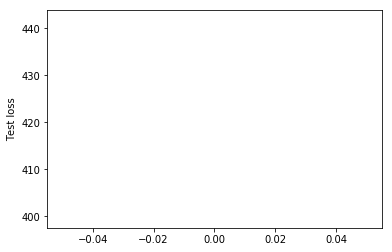

Train Epoch: 2 [0/56781 (0%)]	Loss: 442.625916
Train Epoch: 2 [1280/56781 (2%)]	Loss: 480.221191
Train Epoch: 2 [2560/56781 (5%)]	Loss: 485.908997
Train Epoch: 2 [3840/56781 (7%)]	Loss: 455.984436
Train Epoch: 2 [5120/56781 (9%)]	Loss: 472.475525
Train Epoch: 2 [6400/56781 (11%)]	Loss: 431.036407
Train Epoch: 2 [7680/56781 (14%)]	Loss: 437.912201
Train Epoch: 2 [8960/56781 (16%)]	Loss: 437.528839
Train Epoch: 2 [10240/56781 (18%)]	Loss: 435.802673
Train Epoch: 2 [11520/56781 (20%)]	Loss: 449.799744
Train Epoch: 2 [12800/56781 (23%)]	Loss: 430.786682
Train Epoch: 2 [14080/56781 (25%)]	Loss: 438.658569
Train Epoch: 2 [15360/56781 (27%)]	Loss: 425.861328
Train Epoch: 2 [16640/56781 (29%)]	Loss: 429.544159
Train Epoch: 2 [17920/56781 (32%)]	Loss: 445.477020
Train Epoch: 2 [19200/56781 (34%)]	Loss: 440.773254
Train Epoch: 2 [20480/56781 (36%)]	Loss: 432.772949
Train Epoch: 2 [21760/56781 (38%)]	Loss: 426.799652
Train Epoch: 2 [23040/56781 (41%)]	Loss: 409.723938
Train Epoch: 2 [24320/56781 

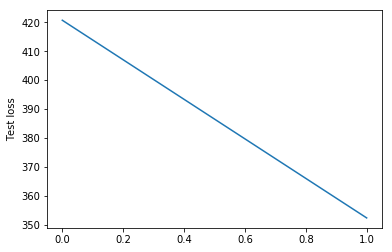

Train Epoch: 3 [0/56781 (0%)]	Loss: 400.679810
Train Epoch: 3 [1280/56781 (2%)]	Loss: 421.796967
Train Epoch: 3 [2560/56781 (5%)]	Loss: 399.140320
Train Epoch: 3 [3840/56781 (7%)]	Loss: 378.577057
Train Epoch: 3 [5120/56781 (9%)]	Loss: 375.134491
Train Epoch: 3 [6400/56781 (11%)]	Loss: 380.592316
Train Epoch: 3 [7680/56781 (14%)]	Loss: 370.299255
Train Epoch: 3 [8960/56781 (16%)]	Loss: 382.495972
Train Epoch: 3 [10240/56781 (18%)]	Loss: 376.869415
Train Epoch: 3 [11520/56781 (20%)]	Loss: 368.748749
Train Epoch: 3 [12800/56781 (23%)]	Loss: 361.691620
Train Epoch: 3 [14080/56781 (25%)]	Loss: 357.329163
Train Epoch: 3 [15360/56781 (27%)]	Loss: 381.224976
Train Epoch: 3 [16640/56781 (29%)]	Loss: 397.125183
Train Epoch: 3 [17920/56781 (32%)]	Loss: 381.958710
Train Epoch: 3 [19200/56781 (34%)]	Loss: 356.157349
Train Epoch: 3 [20480/56781 (36%)]	Loss: 374.078339
Train Epoch: 3 [21760/56781 (38%)]	Loss: 386.340332
Train Epoch: 3 [23040/56781 (41%)]	Loss: 354.023376
Train Epoch: 3 [24320/56781 

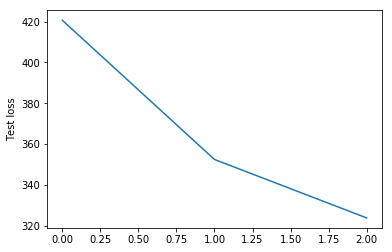

Train Epoch: 4 [0/56781 (0%)]	Loss: 331.759216
Train Epoch: 4 [1280/56781 (2%)]	Loss: 343.452026
Train Epoch: 4 [2560/56781 (5%)]	Loss: 355.867401
Train Epoch: 4 [3840/56781 (7%)]	Loss: 340.550598
Train Epoch: 4 [5120/56781 (9%)]	Loss: 345.829102
Train Epoch: 4 [6400/56781 (11%)]	Loss: 335.612000
Train Epoch: 4 [7680/56781 (14%)]	Loss: 335.578674
Train Epoch: 4 [8960/56781 (16%)]	Loss: 344.492767
Train Epoch: 4 [10240/56781 (18%)]	Loss: 361.440247
Train Epoch: 4 [11520/56781 (20%)]	Loss: 348.051300
Train Epoch: 4 [12800/56781 (23%)]	Loss: 351.258179
Train Epoch: 4 [14080/56781 (25%)]	Loss: 344.381104
Train Epoch: 4 [15360/56781 (27%)]	Loss: 354.507385
Train Epoch: 4 [16640/56781 (29%)]	Loss: 339.754089
Train Epoch: 4 [17920/56781 (32%)]	Loss: 334.269836
Train Epoch: 4 [19200/56781 (34%)]	Loss: 345.468384
Train Epoch: 4 [20480/56781 (36%)]	Loss: 355.694275
Train Epoch: 4 [21760/56781 (38%)]	Loss: 365.764282
Train Epoch: 4 [23040/56781 (41%)]	Loss: 342.887634
Train Epoch: 4 [24320/56781 

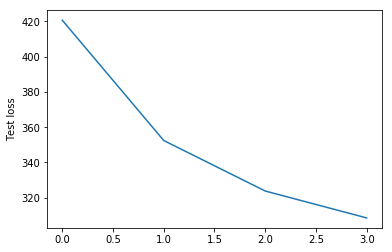

Train Epoch: 5 [0/56781 (0%)]	Loss: 357.242737
Train Epoch: 5 [1280/56781 (2%)]	Loss: 337.467468
Train Epoch: 5 [2560/56781 (5%)]	Loss: 325.703400
Train Epoch: 5 [3840/56781 (7%)]	Loss: 340.781006
Train Epoch: 5 [5120/56781 (9%)]	Loss: 325.560028
Train Epoch: 5 [6400/56781 (11%)]	Loss: 337.348083
Train Epoch: 5 [7680/56781 (14%)]	Loss: 325.791412
Train Epoch: 5 [8960/56781 (16%)]	Loss: 331.052185
Train Epoch: 5 [10240/56781 (18%)]	Loss: 314.654144
Train Epoch: 5 [11520/56781 (20%)]	Loss: 330.569061
Train Epoch: 5 [12800/56781 (23%)]	Loss: 345.875549
Train Epoch: 5 [14080/56781 (25%)]	Loss: 325.627197
Train Epoch: 5 [15360/56781 (27%)]	Loss: 312.186646
Train Epoch: 5 [16640/56781 (29%)]	Loss: 322.183655
Train Epoch: 5 [17920/56781 (32%)]	Loss: 329.326599
Train Epoch: 5 [19200/56781 (34%)]	Loss: 328.272247
Train Epoch: 5 [20480/56781 (36%)]	Loss: 320.207733
Train Epoch: 5 [21760/56781 (38%)]	Loss: 329.269348
Train Epoch: 5 [23040/56781 (41%)]	Loss: 325.169312
Train Epoch: 5 [24320/56781 

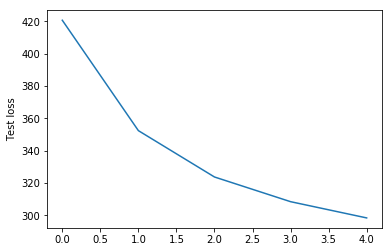

Train Epoch: 6 [0/56781 (0%)]	Loss: 355.989532
Train Epoch: 6 [1280/56781 (2%)]	Loss: 322.250763
Train Epoch: 6 [2560/56781 (5%)]	Loss: 301.836792
Train Epoch: 6 [3840/56781 (7%)]	Loss: 317.787048
Train Epoch: 6 [5120/56781 (9%)]	Loss: 297.615662
Train Epoch: 6 [6400/56781 (11%)]	Loss: 326.646332
Train Epoch: 6 [7680/56781 (14%)]	Loss: 312.506256
Train Epoch: 6 [8960/56781 (16%)]	Loss: 301.315216
Train Epoch: 6 [10240/56781 (18%)]	Loss: 331.606873
Train Epoch: 6 [11520/56781 (20%)]	Loss: 308.706238
Train Epoch: 6 [12800/56781 (23%)]	Loss: 307.480591
Train Epoch: 6 [14080/56781 (25%)]	Loss: 309.266571
Train Epoch: 6 [15360/56781 (27%)]	Loss: 326.695038
Train Epoch: 6 [16640/56781 (29%)]	Loss: 305.557617
Train Epoch: 6 [17920/56781 (32%)]	Loss: 322.302124
Train Epoch: 6 [19200/56781 (34%)]	Loss: 324.147644
Train Epoch: 6 [20480/56781 (36%)]	Loss: 291.374481
Train Epoch: 6 [21760/56781 (38%)]	Loss: 318.231506
Train Epoch: 6 [23040/56781 (41%)]	Loss: 310.786133
Train Epoch: 6 [24320/56781 

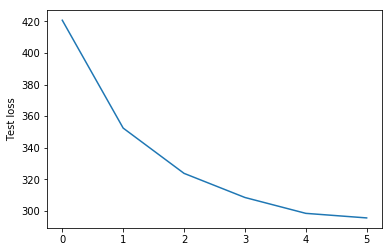

Train Epoch: 7 [0/56781 (0%)]	Loss: 287.874939
Train Epoch: 7 [1280/56781 (2%)]	Loss: 307.431152
Train Epoch: 7 [2560/56781 (5%)]	Loss: 304.182495
Train Epoch: 7 [3840/56781 (7%)]	Loss: 297.952881
Train Epoch: 7 [5120/56781 (9%)]	Loss: 292.027191
Train Epoch: 7 [6400/56781 (11%)]	Loss: 297.729065
Train Epoch: 7 [7680/56781 (14%)]	Loss: 312.978973
Train Epoch: 7 [8960/56781 (16%)]	Loss: 311.207031
Train Epoch: 7 [10240/56781 (18%)]	Loss: 299.485474
Train Epoch: 7 [11520/56781 (20%)]	Loss: 305.457153
Train Epoch: 7 [12800/56781 (23%)]	Loss: 284.890259
Train Epoch: 7 [14080/56781 (25%)]	Loss: 299.403320
Train Epoch: 7 [15360/56781 (27%)]	Loss: 299.703979
Train Epoch: 7 [16640/56781 (29%)]	Loss: 302.440613
Train Epoch: 7 [17920/56781 (32%)]	Loss: 310.904297
Train Epoch: 7 [19200/56781 (34%)]	Loss: 297.064026
Train Epoch: 7 [20480/56781 (36%)]	Loss: 304.133911
Train Epoch: 7 [21760/56781 (38%)]	Loss: 283.570740
Train Epoch: 7 [23040/56781 (41%)]	Loss: 320.578217
Train Epoch: 7 [24320/56781 

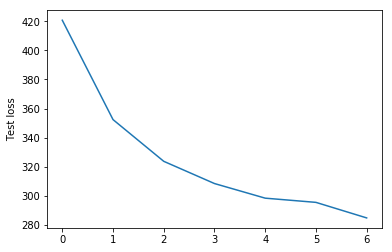

Train Epoch: 8 [0/56781 (0%)]	Loss: 300.103577
Train Epoch: 8 [1280/56781 (2%)]	Loss: 272.924469
Train Epoch: 8 [2560/56781 (5%)]	Loss: 289.054321
Train Epoch: 8 [3840/56781 (7%)]	Loss: 294.637848
Train Epoch: 8 [5120/56781 (9%)]	Loss: 289.330963
Train Epoch: 8 [6400/56781 (11%)]	Loss: 295.078705
Train Epoch: 8 [7680/56781 (14%)]	Loss: 297.212219
Train Epoch: 8 [8960/56781 (16%)]	Loss: 288.465210
Train Epoch: 8 [10240/56781 (18%)]	Loss: 282.341980
Train Epoch: 8 [11520/56781 (20%)]	Loss: 285.293030
Train Epoch: 8 [12800/56781 (23%)]	Loss: 284.734924
Train Epoch: 8 [14080/56781 (25%)]	Loss: 279.725464
Train Epoch: 8 [15360/56781 (27%)]	Loss: 279.336090
Train Epoch: 8 [16640/56781 (29%)]	Loss: 300.314819
Train Epoch: 8 [17920/56781 (32%)]	Loss: 295.885803
Train Epoch: 8 [19200/56781 (34%)]	Loss: 304.090027
Train Epoch: 8 [20480/56781 (36%)]	Loss: 296.690735
Train Epoch: 8 [21760/56781 (38%)]	Loss: 281.904602
Train Epoch: 8 [23040/56781 (41%)]	Loss: 283.167908
Train Epoch: 8 [24320/56781 

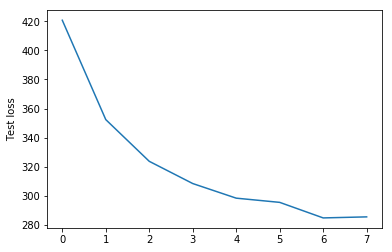

Train Epoch: 9 [0/56781 (0%)]	Loss: 282.876892
Train Epoch: 9 [1280/56781 (2%)]	Loss: 280.507690
Train Epoch: 9 [2560/56781 (5%)]	Loss: 270.921356
Train Epoch: 9 [3840/56781 (7%)]	Loss: 307.338013
Train Epoch: 9 [5120/56781 (9%)]	Loss: 300.149048
Train Epoch: 9 [6400/56781 (11%)]	Loss: 286.664673
Train Epoch: 9 [7680/56781 (14%)]	Loss: 277.620667
Train Epoch: 9 [8960/56781 (16%)]	Loss: 272.216278
Train Epoch: 9 [10240/56781 (18%)]	Loss: 274.865631
Train Epoch: 9 [11520/56781 (20%)]	Loss: 278.650177
Train Epoch: 9 [12800/56781 (23%)]	Loss: 283.514160
Train Epoch: 9 [14080/56781 (25%)]	Loss: 271.618530
Train Epoch: 9 [15360/56781 (27%)]	Loss: 272.614502
Train Epoch: 9 [16640/56781 (29%)]	Loss: 290.710144
Train Epoch: 9 [17920/56781 (32%)]	Loss: 265.193176
Train Epoch: 9 [19200/56781 (34%)]	Loss: 291.089874
Train Epoch: 9 [20480/56781 (36%)]	Loss: 280.787720
Train Epoch: 9 [21760/56781 (38%)]	Loss: 261.012665
Train Epoch: 9 [23040/56781 (41%)]	Loss: 293.599060
Train Epoch: 9 [24320/56781 

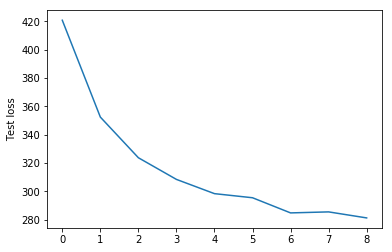

Train Epoch: 10 [0/56781 (0%)]	Loss: 280.091309
Train Epoch: 10 [1280/56781 (2%)]	Loss: 278.075500
Train Epoch: 10 [2560/56781 (5%)]	Loss: 275.845428
Train Epoch: 10 [3840/56781 (7%)]	Loss: 264.497711
Train Epoch: 10 [5120/56781 (9%)]	Loss: 269.402802
Train Epoch: 10 [6400/56781 (11%)]	Loss: 311.527649
Train Epoch: 10 [7680/56781 (14%)]	Loss: 271.610870
Train Epoch: 10 [8960/56781 (16%)]	Loss: 265.755737
Train Epoch: 10 [10240/56781 (18%)]	Loss: 265.612122
Train Epoch: 10 [11520/56781 (20%)]	Loss: 270.407471
Train Epoch: 10 [12800/56781 (23%)]	Loss: 263.832581
Train Epoch: 10 [14080/56781 (25%)]	Loss: 261.538635
Train Epoch: 10 [15360/56781 (27%)]	Loss: 282.090698
Train Epoch: 10 [16640/56781 (29%)]	Loss: 279.889343
Train Epoch: 10 [17920/56781 (32%)]	Loss: 278.340759
Train Epoch: 10 [19200/56781 (34%)]	Loss: 276.165894
Train Epoch: 10 [20480/56781 (36%)]	Loss: 264.863251
Train Epoch: 10 [21760/56781 (38%)]	Loss: 288.241486
Train Epoch: 10 [23040/56781 (41%)]	Loss: 257.474182
Train Epo

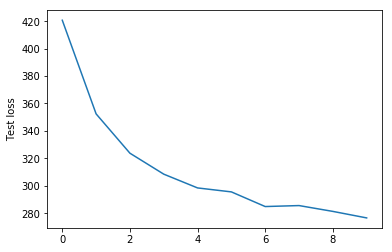

In [59]:
if __name__ == "__main__":
    all_losses = []
    for epoch in range(1, epochs + 1):
        train(epoch)
        test_loss = test(epoch)
        all_losses.append(test_loss)

        plt.plot(all_losses)
        plt.ylabel('Test loss')
        plt.show()

        with torch.no_grad():
            sample = torch.randn(batch_size, embedding_dim).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(batch_size, nb_channels, x_dim, y_dim),
                     'results/sample_' + str(epoch) + '.png')

In [60]:
!ls results/

reconstruction_10.png  reconstruction_5.png  sample_10.png  sample_5.png
reconstruction_1.png   reconstruction_6.png  sample_1.png   sample_6.png
reconstruction_2.png   reconstruction_7.png  sample_2.png   sample_7.png
reconstruction_3.png   reconstruction_8.png  sample_3.png   sample_8.png
reconstruction_4.png   reconstruction_9.png  sample_4.png   sample_9.png


In [0]:
from IPython.display import Image
Image("results/sample_10.png")

In [0]:
from IPython.display import Image
with torch.no_grad():
    sample = torch.randn(batch_size, embedding_dim).to(device)
    sample = model.decode(sample).cpu()
    save_image(sample.view(batch_size, nb_channels, x_dim, y_dim),
             'test_sample.png')
Image("test_sample.png")